<center>
<img src="Stone_Soup_Icon_Final_small.png">
<h1>Stone Soup Alpha Demo</h1>
Demonstrating the capabilities of Stone Soup at Alpha release with Kalman and Particle based trackers
</center>

Initially, we'll set up some initial import and a plotting method which we'll use later.

In [1]:
#General imports and plotting
import datetime
import numpy as np

# Plotting
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-colorblind')

def plot_data(groundtruth_paths, detections, tracks):
    from stonesoup.types.detection import Clutter
    data = np.array([detection.state_vector for detection in detections if not isinstance(detection, Clutter)])
    if data.any():
        plt.plot(data[:,0], data[:, 1], linestyle='', marker='o')

    data = np.array([detection.state_vector for detection in detections if isinstance(detection, Clutter)])
    if data.any():
        plt.plot(data[:,0], data[:, 1], linestyle='', marker='2')

    for path in groundtruth_paths:  
        data = np.array([state.state_vector for state in path])
        plt.plot(data[:, 0], data[:, 2], linestyle=':', marker='')

    from stonesoup.types.prediction import Prediction
    for track in tracks:
        if len([state for state in track.states if not isinstance(state, Prediction)]) < 2:
            continue  # Don't plot tracks with only one detection associated; probably clutter
        data = np.array([state.state_vector for state in track.states])
        plt.plot(data[:, 0], data[:, 2], linestyle='-', marker='.')
        if hasattr(track.state, 'particles'):
            data = np.array([particle.state_vector for state in track.states for particle in state.particles])
            plt.plot(data[:,0], data[:,2], linestyle='', marker=".", markersize=1, alpha=0.5)

    plt.xlabel("$x$")        
    plt.ylabel("$y$")
    custom_legend = [
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='', marker='o'),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='', marker='2'),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle=':', marker=''),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='-', marker='.'),
        matplotlib.lines.Line2D([0], [0], color='0', linestyle='', marker='.', markersize=1),
    ]
    plt.legend(custom_legend,
               ['Detections', 'Clutter', 'Path', 'Track', 'Particles'])

Generating Data
----------------
First we'll create some models, which will be used to generate data.

This will include a 2D-position constant velocity transition model ($x$, $\dot{x}$, $y$ and $\dot{y}$) generated by combining two 1D models (this allows multiple models to be mixed and generation of *n*-dimension models).

In [2]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel,\
                                               ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(1), ConstantVelocity(1)))

And a measurement model, which will map the position based detections ($x$ and $y$) to the position in the state.

In [3]:
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4, mapping=[0, 2], noise_covar=np.diag([10, 10]))

Next we'll create a multi-target ground truth simulation in order to generate some data for testing the tracking algorithms. This utilises the *transition model* to generate the ground truth paths, initialised at random by sampling from a *Gaussian State*. A ground truth track/path at each timestamp is created at a random *birth rate* ($\lambda$ in Poisson distribution), and randomly killed by a *death probability*.

In [4]:
from stonesoup.simulator.simple import MultiTargetGroundTruthSimulator
from stonesoup.types.state import GaussianState
from stonesoup.types.array import StateVector, CovarianceMatrix

groundtruth_sim = MultiTargetGroundTruthSimulator(
    transition_model=transition_model,
    initial_state=GaussianState(
        StateVector([[0], [0], [0], [0]]),
        CovarianceMatrix(np.diag([1000000, 10, 1000000, 10]))),
    timestep=datetime.timedelta(seconds=5),
    birth_rate=0.3,
    death_probability=0.05
)

Next we'll create a detection simulator which will generate detections based on a *detection probability* about the ground truth, utilising the *measurement model*. This model will also create clutter in our defined *measurement range*.

In [5]:
from stonesoup.simulator.simple import SimpleDetectionSimulator

detection_sim = SimpleDetectionSimulator(
    groundtruth=groundtruth_sim,
    measurement_model=measurement_model,
    meas_range=np.array([[-1, 1], [-1, 1]])*5000,  # Area to generate clutter
    detection_probability=0.9,
    clutter_rate=3,
)

With this set up, we'll now run the detection simulator (which will draw truth from the ground truth simulator) and save it to a temporary file, utilising Stone Soup's customised [YAML](http://yaml.org/) object serialisation.

In [6]:
from stonesoup.writer.yaml import YAMLWriter
import tempfile
file = tempfile.NamedTemporaryFile(prefix="soup_", delete=False)
file.close()  # Close it here as we'll open again for writing.

with YAMLWriter(path=file.name, groundtruth_source=groundtruth_sim, detections_source=detection_sim) as writer:
    writer.write()

We'll now open this with a reader, ready for processing by the tracker.

*Note:the simulator could be passed directly to the tracker, but we want to reuse this data for both a Kalman and Particle based tracker in this demo*

In [7]:
from stonesoup.reader.yaml import YAMLReader
detections_source = YAMLReader(file.name)

Building Kalman tracker components
------------------------------------

With the detection data ready, we'll now build a Kalman tracker. For this we will need a Kalman predictor, which will utilise the same *transition model* we used in the ground truth simulator.

In [8]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

And a Kalman updater, utilising the same *measurement model* we used in the detection simulator.

In [9]:
from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

We will also need a data associator to link detections to the "correct" track for the update step: in this case a Nearest Neighbour is fine for this demo. The data associator requires a hypothesiser which calculates some form of score/probability of each track being associated to each detection: in this case using a Mahalanobis distance from track prediction to the detection (which will also generate missed detection hypothesis).

In [10]:
from stonesoup.hypothesiser.distance import MahalanobisDistanceHypothesiser
hypothesiser = MahalanobisDistanceHypothesiser(predictor, updater)

In [11]:
from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser)

And finally a initiator to generate tracks from unassociated detections, in this case a single point initiator generating a track for every unassociated detection.

In [12]:
from stonesoup.initiator.simple import SinglePointInitiator
initiator = SinglePointInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([10000, 100, 10000, 1000])),
    measurement_model=measurement_model)

And a deleter to remove tracks, for this demo simply based on large covariance threshold.

In [13]:
from stonesoup.deleter.simple import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=1E3)

Running the Kalman tracker
---------------------------
With all the components in place, we'll now construct the tracker with a multi target tracker.

In [14]:
from stonesoup.tracker.simple import MultiTargetTracker
tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=detections_source,
    data_associator=data_associator,
    updater=updater,
)

In [15]:
tracks = set()
groundtruth_paths = set()  # Store for plotting later
detections = set()  # Store for plotting later
for time, ctracks in tracker.tracks_gen():
    tracks.update(ctracks)
    detections |= tracker.detector.detections
    groundtruth_paths |= tracker.detector.groundtruth_paths

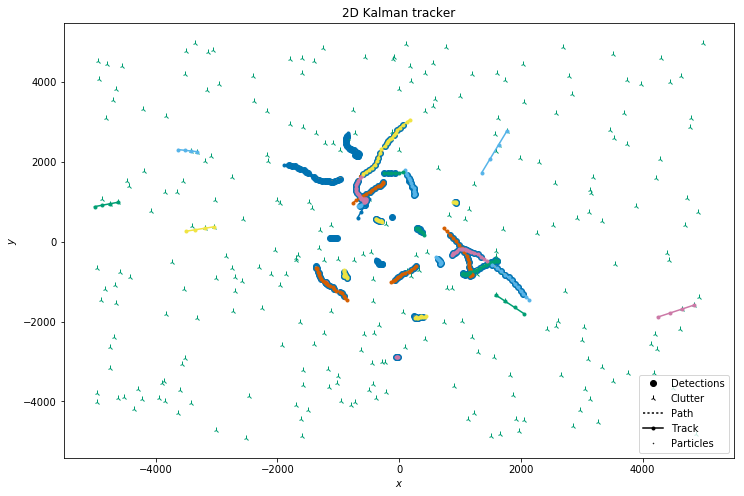

In [16]:
plot_data(groundtruth_paths, detections, tracks);plt.title("2D Kalman tracker");

Note: Colours are random to help differentiate overlapping data.

In [ ]:
plot_data(groundtruth_paths, detections, tracks);plt.title("2D Kalman tracker - zoom");plt.xlim(-2000, 2000);plt.ylim(-2000, 2000);

Note: Colours are random to help differentiate overlapping data.

Running a Particle Tracker
---------------------------
Now we'll run a particle tracker against the same detection set.

First we'll need to replace the predictor with our Particle predictor.

In [ ]:
from stonesoup.predictor.particle import ParticlePredictor
particle_predictor = ParticlePredictor(transition_model)

And also replace the updater with a particle updater. This also requires a resampler for the particles to split high weight particles and remove low weight particles.

In [ ]:
from stonesoup.updater.particle import ParticleUpdater
from stonesoup.resampler.particle import SystematicResampler
particle_updater = ParticleUpdater(measurement_model, SystematicResampler())

We'll also use the same initiator, but wrap it with an initiator that samples particles from the Gaussian state.

In [ ]:
from stonesoup.initiator.simple import GaussianParticleInitiator
particle_initiator = GaussianParticleInitiator(
    initiator=initiator,
    number_particles=200)

And now with particle based initiator, updater and predictor, we can create a particle tracker, with the same tracker class.

In [ ]:
particle_tracker = MultiTargetTracker(
    initiator=particle_initiator,
    deleter=deleter,
    detector=detections_source,
    data_associator=NearestNeighbour(
        MahalanobisDistanceHypothesiser(particle_predictor, particle_updater)),
    updater=particle_updater,
)

And finally run the particle tracker.

In [ ]:
particle_tracks = set()
for time, ctracks in particle_tracker.tracks_gen():
    particle_tracks.update(ctracks)

In [ ]:
plot_data(groundtruth_paths, detections, particle_tracks);plt.title("2D Particle tracker");

Note: Colours are random to help differentiate overlapping data.

In [ ]:
plot_data(groundtruth_paths, detections, particle_tracks);plt.title("2D Particle tracker");plt.xlim(-2000, 2000);plt.ylim(-2000, 2000);

In [ ]:
plot_data(groundtruth_paths, detections, tracks);plt.title("2D Kalman tracker");plt.xlim(-2000, 2000);plt.ylim(-2000, 2000);

Note: Colours are random to help differentiate overlapping data.

Configuration
-------------
This can then be saved and shared with others via a configuration file. (In this example, reconfigured to run the simulator as well)

In [ ]:
particle_tracker = MultiTargetTracker(
    initiator=particle_initiator,
    deleter=deleter,
    detector=detection_sim,
    data_associator=NearestNeighbour(
        MahalanobisDistanceHypothesiser(particle_predictor, particle_updater)),
    updater=particle_updater,
)

In [ ]:
from stonesoup.serialise import YAML
print(YAML().dumps(particle_tracker))